In [1]:
import numpy as np
from skimage.transform import resize
from skimage import color
import matplotlib.pyplot as plt
import IPython

%load_ext autoreload
%autoreload 2
%matplotlib inline

def scale_data(vol, seg, size=180):
    length = vol.shape[0]
    vol = resize(vol, (length, size, size))
    seg = resize(seg, (length, size, size), order=0, preserve_range=True, anti_aliasing=False)

    return (vol, seg)
    
def label_data(vol, seg):
    length = vol.shape[0]
    x = vol.shape[1]
    y = vol.shape[2]
    # reshape for labeling
    seg = np.reshape(seg, (length, x*y) )
    vol = np.reshape(vol, (length, x*y) )
    # label
    labeled = color.label2rgb(seg, vol, alpha=0.1, bg_label=-1)
    # shape back
    labeled = np.reshape(labeled, (length, x, y, 3) )

    return labeled

def vis_volume(volume, fig_size=6.5):
    length = volume.shape[0]
    
    # set up
    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)

    # display
    for i in range(length):
        axes.imshow(volume[i], interpolation='none', filternorm=False, resample=False)
        fig.canvas.draw()
        hfig.update(fig)
        if i != length-1:
            plt.cla()
    # clean up
    IPython.display.clear_output()

def view_patch(patch,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(3,4)
    fig.set_size_inches(16, 10)
    axarr[0,0].imshow(patch.image[0][i], cmap='gray')
    axarr[0,1].imshow(patch.label[0][i], cmap='prism')
    axarr[0,2].imshow(label_data(patch.image[0],patch.label[0])[i])
    axarr[1,0].imshow(patch.affinity[0][i], cmap='gray')
    axarr[1,1].imshow(patch.affinity[1][i], cmap='gray')
    axarr[1,2].imshow(patch.affinity[2][i], cmap='gray')
    axarr[2,0].imshow(patch.get_lsd_channel(0)[i,:,:,0])
    axarr[2,1].imshow(patch.get_lsd_channel(1)[i,:,:,0])
    axarr[2,2].imshow(patch.get_lsd_channel(2)[i,:,:,0])
    axarr[2,3].imshow(patch.get_lsd_channel(3)[i], cmap='gray')
    plt.show()


def view_affinity(affinity,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(1,3)
    fig.set_size_inches(24, 20)
    axarr[0].imshow(affinity[0][i], cmap='gray')
    axarr[1].imshow(affinity[1][i], cmap='gray')
    axarr[2].imshow(affinity[2][i], cmap='gray')
    plt.show()

In [33]:
from neutorch.dataset.affinity import TestDataset
from neutorch.dataset.utils import from_h5
import numpy as np

patch_size =  (26,256,256)
stride = (8,80,80)
begin = []
for i in range(len(patch_size)):
    c = patch_size[i] // 2
    o = stride[i] // 2
    begin.append(c-o)
begin = tuple(begin)
print(begin)
dataset = TestDataset('../../data/sample_A_pad.hdf', patch_size, stride, with_label=True)
full = np.zeros(dataset.full_shape)
print(len(dataset))
print(dataset.full_shape)




(9, 88, 88)
loading from ../../data/sample_A_pad.hdf...
25725
(200, 3072, 3072)


In [3]:
from neutorch.dataset.utils import from_h5

path = '../../data'
file = 'sample_A'

image = from_h5(f'{path}/{file}.hdf', dataset_path='volumes/raw')
label = from_h5(
f'{path}/{file}.hdf', dataset_path='volumes/labels/neuron_ids')

In [2]:
from neutorch.dataset.utils import from_h5
from neutorch.dataset.proofread import ProofreadDataset
import cc3d

path = '../../data'
file = 'sample_C'

image = from_h5(f'{path}/{file}.hdf', dataset_path='volumes/raw')
true_label = from_h5(
f'{path}/{file}.hdf', dataset_path='volumes/labels/neuron_ids')
pred_label = np.load(f'../../swin_run/segmentation_700000_{file}_pad.npy')

pred_label = cc3d.connected_components(pred_label) 


If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [3]:
dataset = ProofreadDataset(image, pred_label, true_label, name=file)


10023190 118336
7077905 105767
6572304 619489
6120930 105575
5449124 625543
4526817 70955
3695330 619486


In [4]:
img, lbl = dataset[0]

118336
indices took 0.959
[ 14   0 209] [  73  669 1249]
(slice(10, 78, None), slice(0, 710, None), slice(169, 1250, None))
crop took 1.79
add channel took 1.102
zero other classes took 0.302
expandtook 11.652
combined 1.49
pad took 2.582
rearrange took 3.957
split 6.707
drop 1.483
pre len: 82261
total vol: 84235264
max_patches 13312
post len: 13312
drop again 0.795


In [6]:
print(img.shape, lbl.shape)

(13312, 4, 1, 16, 16) (13312, 1, 1, 16, 16)


In [8]:

recon = np.zeros((125+1,1250+16,1250+16))
recon_label = np.zeros((125+1,1250+16,1250+16, 3))
for j in range(img.shape[0]):
    patch = img[j]
    seg = lbl[j][0]
    val = patch[0]
    sz = val.shape
    coors = patch[1:]
    st = coors[:,0,0,0].astype(int)
    
    recon[st[0]:st[0]+sz[0],st[1]:st[1]+sz[1],st[2]:st[2]+sz[2]] = val

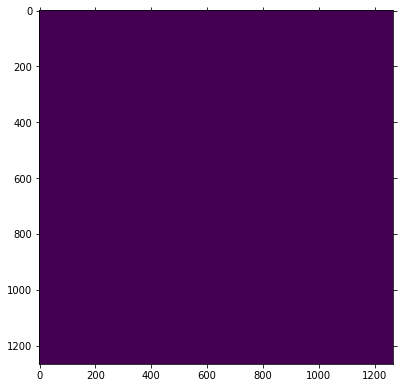

In [9]:
vis_volume(recon)

In [15]:
alt = pred_label.copy()
alt[alt != 64] = 0
alt[alt == 64] = 200

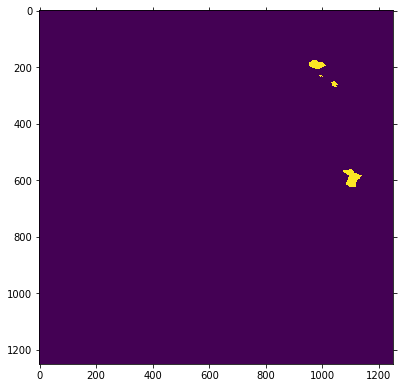

In [17]:
vis_volume(alt)

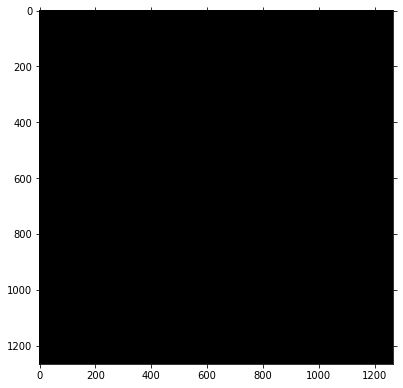

In [72]:
vis_volume(recon_label)